In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import json
import torch
import numpy as np
import cv2
from pathlib import Path
import copy
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation 
from nerfstudio.utils.eval_utils import eval_setup
from inerf.inerf_trainer import load_data_into_trainer
from inerf.inerf_utils import get_corrected_pose, load_eval_image_into_pipeline, get_relative_pose, get_absolute_diff_for_pose, get_image, correct_pose, transform_original_space_to_pose
from plane_nerf.plane_nerf_optimizer import PlaneNerfCameraOptimizer

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [4]:
os.chdir('/workspace')
MODEL_PATH = "/workspace/outputs/jackal_with_box/plane-nerf/2024-02-13_150433"
DATA_PATH = "/stored_data/jackal_one_frame_box"
GROUND_TRUTH_PATH = os.path.join(DATA_PATH, "ground_truth.json")
TRANSFORM_FILE = "transforms.json"
with open(GROUND_TRUTH_PATH) as f:
    GROUND_TRUTH = json.load(f)
with open(os.path.join(DATA_PATH, TRANSFORM_FILE)) as f:
    TRANSFORM = json.load(f)

In [5]:
config_path = os.path.join(MODEL_PATH, "config.yml")
config, pipeline, _, _ = eval_setup(
                        Path(config_path),
                        test_mode="inference",
                    )

pipeline = load_eval_image_into_pipeline(pipeline,DATA_PATH,TRANSFORM)

config.pipeline.datamanager.pixel_sampler.num_rays_per_batch = 4096 

trainer = load_data_into_trainer(
    config,
    pipeline,
    plane_optimizer = True
)
trainer.pipeline.datamanager.KERNEL_SIZE = 5
trainer.pipeline.datamanager.THRESHOLD = 10
trainer.pipeline.datamanager.METHOD = "sift"
trainer.pipeline.datamanager.get_inerf_batch()  

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from 
outputs/jackal_with_box/plane-nerf/2024-02-13_150433/nerfstudio_models/step-000009999.ckpt

/workspace/inerf/inerf/inerf_utils.py:147: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  camera_to_worlds = torch.cat([camera_to_worlds, tensor([tf]).float()], 0)


Setting up training dataset...

Caching all 1 images.

Output()

Loading PlaneNerfCameraOptimizer


[16:26:09] Saving checkpoints to: outputs/jackal_with_box/plane-nerf/2024-02-13_150433/nerfstudio_models  ]8;id=462994;file:///home/user/nerfstudio/nerfstudio/engine/trainer.py\trainer.py]8;;\:]8;id=869063;file:///home/user/nerfstudio/nerfstudio/engine/trainer.py#134\134]8;;\

Loading latest Nerfstudio checkpoint from load_dir...


Done loading Nerfstudio checkpoint from 
outputs/jackal_with_box/plane-nerf/2024-02-13_150433/nerfstudio_models/step-000009999.ckpt

Number of keypoints:  62
Number of rays:  2987
Randomly select more rays
Final number of rays:  4096


In [6]:
ground_truth_poses = []
for _ , batch in pipeline.datamanager.fixed_indices_train_dataloader:
    tf = GROUND_TRUTH["frames"][int(batch['image_idx'])]["transform_matrix"]
    tf = np.asarray(tf)
    tf = tf[:3, :4 ]
    ground_truth_poses.append(tf)
ground_truth_poses = torch.tensor(ground_truth_poses).to(pipeline.device)

In [11]:
ground_truth_poses_in_trainer = transform_original_space_to_pose(ground_truth_poses.to("cpu").float(), 
                                                                trainer.pipeline.datamanager.train_dataparser_outputs.dataparser_transform,
                                                                trainer.pipeline.datamanager.train_dataparser_outputs.dataparser_scale,
                                                                "opengl")

ground_truth_poses_in_trainer[0,0,3] = - 0.65

print(ground_truth_poses_in_trainer)

trainer.pipeline.datamanager.train_dataparser_outputs.cameras.camera_to_worlds = ground_truth_poses_in_trainer.to("cpu")
pipeline.datamanager.train_dataset = pipeline.datamanager.create_train_dataset()
pipeline.datamanager.setup_train()
loss = trainer.get_loss()

corrected_pose = get_corrected_pose(trainer)
relative_pose = get_relative_pose(ground_truth_poses, corrected_pose)
t_diff, r_diff = get_absolute_diff_for_pose(relative_pose)
#Get averrage absolute translation and rotation error
print("Average translation error: ", torch.mean(t_diff))
print("Average rotation error: ", torch.mean(r_diff))
print(loss)
original_img = cv2.imread(os.path.join(DATA_PATH, GROUND_TRUTH["frames"][0]["file_path"]))
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
#rendered_img = get_image(trainer.pipeline, corrected_pose[0:1,:,:])
#rendered_img = rendered_img["rgb"]

tensor(-0.6188)
tensor([[[ 0.7735,  0.4365, -0.4595, -0.6188],
         [-0.6334,  0.5572, -0.5369, -0.6797],
         [ 0.0217,  0.7064,  0.7075,  0.0000]]])


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(1.5429e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(6.4541e-05, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.0222, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.0722], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 3102}


In [8]:
store = []
for theta in range(-45,45,3):
    rotation = Rotation.from_euler('z', theta, degrees=True)
    rotation = rotation.as_matrix()
    rotation = torch.tensor(rotation).unsqueeze(0).float()
    
    new_pose = rotation @ ground_truth_poses_in_trainer
    trainer.pipeline.datamanager.train_dataparser_outputs.cameras.camera_to_worlds = new_pose.to("cpu")
    pipeline.datamanager.train_dataset = pipeline.datamanager.create_train_dataset()
    pipeline.datamanager.setup_train()
    loss = trainer.get_loss()

    corrected_pose = get_corrected_pose(trainer)
    relative_pose = get_relative_pose(ground_truth_poses, corrected_pose)
    t_diff, r_diff = get_absolute_diff_for_pose(relative_pose)
    #Get averrage absolute translation and rotation error
    print("Average translation error: ", torch.mean(t_diff))
    print("Average rotation error: ", torch.mean(r_diff))
    print(loss)

    store.append([theta,float(loss["rgb_loss"]),loss["close_pixels"]])

Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(3.0227e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.7854, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1411, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1911], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 368}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.6983e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.7330, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1404, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1904], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 356}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.7362e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.6807, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1359, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1859], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 357}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(3.2261e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.6283, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1270, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1770], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 426}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(1.8128e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.5760, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1218, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1718], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 401}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.8720e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.5236, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1172, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1672], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 544}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.7059e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.4712, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1140, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1640], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 575}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(3.8136e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.4189, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1124, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1624], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 616}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(1.2273e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.3665, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1105, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1605], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 676}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.6745e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.3142, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1065, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1565], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 764}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(3.2204e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.2618, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1009, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1509], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 909}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.5115e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.2094, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.0904, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1404], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 1146}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.6518e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.1571, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.0749, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1249], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 1456}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.5917e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.1047, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.0567, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1067], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 1967}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.9894e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.0524, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.0345, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.0845], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 2675}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(1.5429e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(6.4541e-05, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.0222, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.0722], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 3102}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.8141e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.0524, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.0404, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.0904], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 2443}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.4924e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.1047, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.0624, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1124], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 1813}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(3.2427e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.1571, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.0798, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1298], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 1422}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.5115e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.2094, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.0916, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1416], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 1162}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(3.0658e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.2618, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1500], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 945}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(4.6110e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.3142, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1044, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1544], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 808}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(3.9236e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.3665, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1056, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1556], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 712}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(4.5391e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.4189, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1082, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1582], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 674}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.8010e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.4712, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1107, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1607], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 635}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.5218e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.5236, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1143, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1643], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 594}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.5840e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.5760, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1155, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1655], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 589}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.3192e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.6283, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1163, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1663], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 567}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.3390e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.6807, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1194, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1694], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 551}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.7362e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.7330, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1223, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1723], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 516}


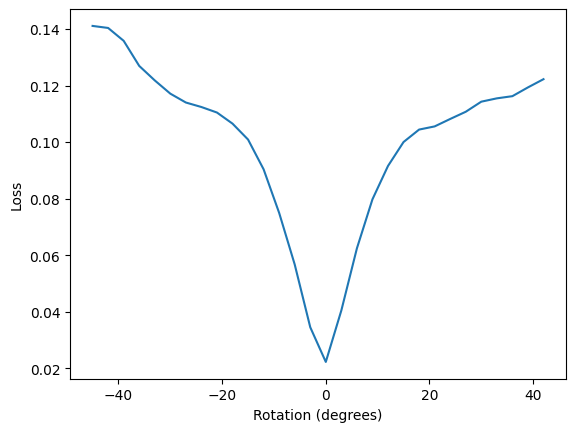

In [9]:
#Plot theta against results
store = np.array(store)
plt.plot(store[:,0],store[:,1])
plt.xlabel("Rotation (degrees)")
plt.ylabel("Loss")
plt.show()